# <h1 style='Text-align: center;'>**Thesis Project - ThorX Neural Notebook v1.0**</h1>
# <h1 style='Text-align: center;'>Deployment of Machine Learning Model for Web Site in Covid-19 Detection</h1>

`Created by: Erick Eduardo Robledo Montes`

---
---
<p style='Text-align: justify;'><i>Objective:</i> Predict Covid-19, Viral Pneumonia or Normal classes with features derived from chest X-Ray images. </p>

## Content

1. [Background](#Background)
1. [Sources](#Sources)
1. [Libraries](#Libraries)
1. [Tensorflow-GPU](#Tensorflow-GPU)
1. [Variables](#Variables)
1. [Transformers](#Transformers)
1. [Data](#Data)
1. [ShuffleSplit](#ShuffleSplit)
1. [Train](#Train)
1. [Evaluation](#Evaluation)

## Background

<p style='Text-align: justify;'>This notebook uses chest X-Ray images from <i>"COVID-19 Radiography Database"</i>, hosted on the website <i>Kaggle</i> which includes 15,153 images splited in three folders:</p> 

* *COVID-19* 
* *Viral Pneumonia*
* *Normal*

<p style='Text-align: justify;'>For this illustration, we manage to use Transfer Learning and adapt our own neural network model at the <i>output</i> of the convolutional neural network <i>VGG16</i> to develop multiclass classificators with <i>Tensorflow-GPU</i>, in order to allow using the computer's GPU to accelerate the training of this models.</p>

## Sources

* *COVID-19 Radiography Database: [https://www.kaggle.com/datasets/tawsifurrahman/covid19-radiography-database]*
* *Towards Data Science: [https://towardsdatascience.com/a-look-at-precision-recall-and-f1-score-36b5fd0dd3ec]*
* *Sci-kit Learn Org: [https://scikit-learn.org/stable/modules/generated/sklearn.metrics.precision_recall_fscore_support.html]*
* *Towards Data Science - Confusion Matrix and Class Statistics: [https://towardsdatascience.com/confusion-matrix-and-class-statistics-68b79f4f510b]*

---


## Libraries

We'll import all the Python libraries.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from sklearn.preprocessing import (
    LabelEncoder,
    LabelBinarizer,
)
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import (
    classification_report,
    accuracy_score,
    confusion_matrix,
    roc_auc_score, #
    plot_roc_curve, #
    roc_curve,
    auc,
) 
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers
from tensorflow.keras.regularizers import l2
from tensorflow.keras.models import (
    Model,
    load_model,
)
from tensorflow.keras.applications import VGG16, VGG19
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import (
    EarlyStopping, 
    ModelCheckpoint,
) 
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.base import BaseEstimator, TransformerMixin
import glob
import cv2
import random

---
## Tensorflow-GPU

Testing if there's a GPU in the computer to use on the training of the Neural Network Model to fast forward the proccess.

Using `tf.test.gpu_device_name()` in order to confirm if there´s a GPU device in the computer.

In [2]:
device_name = tf.test.gpu_device_name()
if "GPU" not in device_name: print("GPU device not found")
else: print('Found GPU at: {}'.format(device_name))

plt.rcParams['figure.figsize'] = [8.0, 8.0]
plt.rcParams['figure.dpi'] = 100

Found GPU at: /device:GPU:0


---
## Variables

Now we will set all the constant variables in all the project.

In [24]:
# IMPLEMENTAR 1330 MUESTRAS CON 38 DE BATCH SIZE

RAW_DATASET_PATH = "../datasets/raw_dataset/"
RAW_DATASET_NAME = "raw_data_4035"
PREDICTED_DATASET_PATH = "../datasets/predicted_dataset/"
PREDICTED_DATASET_NAME = "resnet50_predicted_data_4035_dataug_v1"

# FIRST REPOSITORY

PNEUMONIA_PATH = "../COVID-19_Radiography_Dataset/Viral Pneumonia/images/"
COVID_19_PATH = "../COVID-19_Radiography_Dataset/COVID/images/"
#LUNG_OPACITY_PATH = "../COVID-19_Radiography_Dataset/Lung_Opacity/images/"
NORMAL_PATH = "../COVID-19_Radiography_Dataset/Normal/images/"

# SECOND REPOSITORY

#PNEUMONIA_PATH_1 = "../Lung Segmentation Data/Train/Non-COVID/images/"
#PNEUMONIA_PATH_2 = "../Lung Segmentation Data/Test/Non-COVID/images/"
#PNEUMONIA_PATH_3 = "../Lung Segmentation Data/Val/Non-COVID/images/"
#
#COVID_19_PATH_1 = "../Lung Segmentation Data/Train/COVID-19/images/"
#COVID_19_PATH_2 = "../Lung Segmentation Data/Test/COVID-19/images/"
#COVID_19_PATH_3 = "../Lung Segmentation Data/Val/COVID-19/images/"
#
#NORMAL_PATH_1 = "../Lung Segmentation Data/Train/Normal/images/"
#NORMAL_PATH_2 = "../Lung Segmentation Data/Test/Normal/images/"
#NORMAL_PATH_3 = "../Lung Segmentation Data/Val/Normal/images/"

MODEL_PATH = "../models/"
MODEL_NAME = "resnet50_8020_64_4035_50_dataug_v1"

ROC_PATH = "../reports/roc/"
ACCURACY_PATH = "../reports/accuracy/"
LOSS_PATH = "../reports/loss/"
ACCURACY_LOSS_PATH = "../reports/accuracy_loss/"
CONFUSION_MATRIX_PATH = "../reports/confusion_matrix/"

LABELS = [ 
        "Viral Pneumonia", 
        "COVID-19", 
        "NORMAL",
] 

CLASSES = [
    "COVID-19", 
    "NORMAL", 
    "Viral Pneumonia"
] 
#LABELS = ["Viral Pneumonia", "COVID-19", "Lung Opacity", "NORMAL"] 
#CLASSES = ["Viral Pneumonia", "COVID-19", "Lung Opacity", "NORMAL"] 

SAMPLES = 1345

TEST_SIZE = 0.20
VALIDATION_SIZE = 0.15

IMG_RESOLUTION = (64, 64)
WIDTH = 64
HEIGHT = 64

BS = 38
EPOCHS = 49

SEED = 42
SEED_MODEL = 42
SEED_SPLIT = 42
SEED_VALIDATION = 82

#INIT_LR = 5e-4
INIT_LR = 3e-4
DECAY = 1e-6

---
## Transformers

We will be able to call back these Transformers classes along the project.

In [3]:
class Files:

    def __init__(self, samples : int, random_seed : int):
        self.samples = samples
        self.random_seed = random_seed
        self.pneumonia_path = str
        self.covid19_path = str
        self.normal_path = str
        self.array = []
    
    def file_paths(self, pneumonia_path : str, covid19_path : str, normal_path : str):
        pneumonia_paths = glob.glob(pneumonia_path + "/*")
        covid19_paths = glob.glob(covid19_path + "/*")
        normal_paths = glob.glob(normal_path + "/*")

        random.seed(self.random_seed)
        random.shuffle(pneumonia_paths)
        random.shuffle(covid19_paths)
        random.shuffle(normal_paths)

        images_paths = pneumonia_paths[:self.samples] + covid19_paths[:self.samples] + normal_paths[:self.samples] 
        return images_paths

    def file_labels(self, images_paths : list):
        for i in range(len(images_paths)):
            if i < len(images_paths) / 3:
                self.array.append("pneumonia")
            elif i >= len(images_paths) / 3 and i < (len(images_paths) * (2/3)):
                self.array.append("covid")
            elif i >= (len(images_paths) * (2/3)):
                self.array.append("normal")
        return self.array
        

class DataPreprocessing(BaseEstimator, TransformerMixin):

    def __init__(self, img_resolution : list):
        self.img_resolution = img_resolution
        self.array = []

    def fit(self, filepath : list, y=0): 
        for i in range(len(filepath)):
            image = cv2.imread(filepath[i])
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            image = cv2.resize(image, self.img_resolution)
            R, G, B = cv2.split(image)                          
            output1_R = cv2.equalizeHist(R)                     
            output1_G = cv2.equalizeHist(G)                     
            output1_B = cv2.equalizeHist(B)                     
            preprocessed_img = cv2.merge((output1_R, output1_G, output1_B))  
            self.array.append(preprocessed_img)                           
        return self.array
    
    def transform(self, filepath : list, y=0):
        return self.array

class DataLabeling(BaseEstimator, TransformerMixin):

    def __init__(self):
        self.encoder = []
    
    def fit(self, labels : list, y = 0):      
        label_encoder = LabelEncoder()
        self.encoder = label_encoder.fit_transform(labels)
        self.encoder = to_categorical(self.encoder)
        return self.encoder

    def transform(self, labels : list, y = 0):
        return self.encoder

class HeadModel(BaseEstimator, TransformerMixin):

    def __init__(self):
        self.headmodel_output= self

    def fit(self, basemodel, y = 0):
        headmodel_input = basemodel.output
        flat = layers.Flatten(name = 'flatten')(headmodel_input)
        dense1 = layers.Dense(64,
              kernel_regularizer=l2(0.025),      
              bias_regularizer=l2(0.025))(flat)
        activation1 = layers.Activation('relu')(dense1)
        dense2 = layers.Dense(64, activation = 'relu')(activation1)
        dropout2 = layers.Dropout(0.5)(dense2)
        self.headmodel_output = layers.Dense(3, activation = 'softmax')(dropout2)
        return self.headmodel_output
    
    def transform(self, basemodel, y = 0):
        return self.headmodel_output

class ModelChart:

    def __init__(self, history, model_name : str, epochs : int):
        self.history = history
        self.model_name = model_name
        self.epochs = epochs

    def loss_accuracy_chart(self, path : str):
        N = self.epochs

        plt.style.use("ggplot")
        plt.figure(figsize = (10, 8))
        plt.plot(self.history.history["loss"], label="train_loss")
        plt.plot(self.history.history["val_loss"], label="val_loss")
        plt.plot(self.history.history["accuracy"], label="train_acc")
        plt.plot(self.history.history["val_accuracy"], label="val_acc")
        plt.title("Model Training Loss and Accuracy: " + self.model_name)
        plt.xlabel("Epochs #")
        plt.ylabel("Loss/Accuracy")
        plt.legend(loc="lower left")
        plt.savefig(path + 'loss_accuracy_' + self.model_name + '.png')
        plt.show()

    def accuracy_chart(self, path : str):
        plt.style.use('ggplot')
        plt.figure(figsize = (10, 8))
        plt.plot(self.history.history['accuracy'])
        plt.plot(self.history.history['val_accuracy'])
        plt.title('Model Accuracy: ' + self.model_name)
        plt.ylabel('Accuracy')
        plt.xlabel('Epochs #')
        plt.legend(['train', 'validation'], loc='lower right')
        plt.savefig(path + 'accuracy_' + self.model_name + '.png')
        plt.show()

    def loss_chart(self, path : str):
        plt.style.use('ggplot')
        plt.figure(figsize = (10, 8))
        plt.plot(self.history.history['loss'])
        plt.plot(self.history.history['val_loss'])
        plt.title('Model Loss:' + self.model_name)
        plt.ylabel('Loss')
        plt.xlabel('Epochs #')
        plt.legend(['train', 'validation'], loc='upper left')
        plt.savefig(path + 'loss_' + self.model_name + '.png')
        plt.show()

class ModelEvaluation:

    def __init__(self, conf_matrix : np.asarray, model_name : str):
        self.conf_matrix = conf_matrix
        self.model_name = model_name

    def confusion_matrix(self, path : str, labels : list):
        df_cm= pd.DataFrame(self.conf_matrix, columns = labels, 
            index = labels)
        df_cm.index.name = 'Original'
        df_cm.columns.name = 'Predicted'
        plt.figure(figsize = (8,8))
        plt.title('Confusion Matrix - ' + self.model_name)
        sns.heatmap(df_cm/np.sum(df_cm), fmt='.2%', annot = True, annot_kws={'size':16})
        plt.savefig(path + 'confusion_matrix_' + self.model_name + '.png')
        plt.show()
    
    def parameters(self):
        TP_pneumonia = conf_matrix[0,0]
        FN_pneumonia = conf_matrix[0,1] + conf_matrix[0,2] 
        FP_pneumonia = conf_matrix[1,0] + conf_matrix[2,0] 
        TN_pneumonia = conf_matrix[1,1] + conf_matrix[1,2] + conf_matrix[2,1] + conf_matrix[2,2] 

        sensit_pneumonia = TP_pneumonia / (TP_pneumonia + FN_pneumonia)
        spec_pneumonia = TN_pneumonia / (FP_pneumonia + TN_pneumonia)
        prec_pneumonia = TP_pneumonia / (TP_pneumonia + FP_pneumonia)
        fscore_pneumonia = 2 * (sensit_pneumonia * prec_pneumonia) / (sensit_pneumonia + prec_pneumonia)

        TP_covid = conf_matrix[1,1] 
        FN_covid = conf_matrix[1,0] + conf_matrix[1,2] 
        FP_covid = conf_matrix[0,1] + conf_matrix[2,1] 
        TN_covid = conf_matrix[0,0] + conf_matrix[0,2] + conf_matrix[2,0] + conf_matrix[2,2] 

        sensit_covid = TP_covid / (TP_covid + FN_covid)
        spec_covid = TN_covid / (FP_covid + TN_covid)
        prec_covid = TP_covid / (TP_covid + FP_covid)
        fscore_covid = 2 * (sensit_covid * prec_covid) / (sensit_covid + prec_covid)

        TP_normal = conf_matrix[2,2]
        FN_normal = conf_matrix[2,0] + conf_matrix[2,1]
        FP_normal = conf_matrix[0,2] + conf_matrix[1,2]
        TN_normal = conf_matrix[0,0] + conf_matrix[0,1] + conf_matrix[1,0] + conf_matrix[1,1] 

        sensit_normal = TP_normal / (TP_normal + FN_normal)
        spec_normal = TN_normal / (FP_normal + TN_normal)
        prec_normal = TP_normal / (TP_normal + FP_normal)
        fscore_normal = 2 * (sensit_normal * prec_normal) / (sensit_normal + prec_normal)

        accuracy = (self.conf_matrix[0,0] + self.conf_matrix[1,1] + self.conf_matrix[2,2]) / sum(sum(self.conf_matrix))
        print("Test Model Accuracy: {:.4f}".format(accuracy))
        print(f". . .")
        print("Viral Pneumonia Sensitivity: {:.4f}".format(sensit_pneumonia))
        print("Viral Pneumonia Specificity: {:.4f}".format(spec_pneumonia))
        print("Viral Pneumonia Precision: {:.4f}".format(prec_pneumonia))
        print("Viral Pneumonia F1-Score: {:.4f}".format(fscore_pneumonia))
        print(f". . .")
        print("COVID-19 Sensitivity: {:.4f}".format(sensit_covid))
        print("COVID-19 Specificity: {:.4f}".format(spec_covid))
        print("COVID-19 Precision: {:.4f}".format(prec_covid))
        print("COVID-19 F1-Score: {:.4f}".format(fscore_covid))
        print(f". . .")
        print("NORMAL Sensitivity: {:.4f}".format(sensit_normal))
        print("NORMAL Specificity: {:.4f}".format(spec_normal))
        print("NORMAL Precision: {:.4f}".format(prec_normal))
        print("NORMAL F1-Score: {:.4f}".format(fscore_normal))

class ROC:
    def __init__(self):
        pass
    
    def ROC_Curve(self, y_test, prob_pred):
        encoder = LabelEncoder()
        binarizer = LabelBinarizer()

        y_encoded_test = encoder.fit_transform(y_test.argmax(axis=1))
        y_test_bin = binarizer.fit_transform(y=y_encoded_test)

        y_score = prob_pred

        fpr = dict()
        tpr = dict()
        roc_auc = dict()
        for i in range(len(LABELS)):
            fpr[i], tpr[i], _ = roc_curve(
                y_test_bin[:, i], 
                y_score[:, i]
            )
            roc_auc[i] = auc(
                fpr[i], 
                tpr[i]
            )

        # Compute micro-average ROC curve and ROC area
        fpr["micro"], tpr["micro"], _ = roc_curve(
            y_test_bin.ravel(),
            y_score.ravel()
        )
        roc_auc["micro"] = auc(
            fpr["micro"], 
            tpr["micro"]
        )

        # First aggregate all false positive rates
        all_fpr = np.unique(
            np.concatenate(
                [fpr[i] for i in range(len(LABELS))]
            )
        )

        # Then interpolate all ROC curves at this points
        mean_tpr = np.zeros_like(all_fpr)
        for i in range(len(LABELS)):
            mean_tpr += np.interp(
                all_fpr, 
                fpr[i], 
                tpr[i]
            )

        # Finally average it and compute AUC
        mean_tpr /= len(LABELS) 

        fpr["macro"] = all_fpr
        tpr["macro"] = mean_tpr
        roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

        plt.style.use('ggplot')
        plt.figure(figsize=(10,8))

        for i in range(len(LABELS)):
            plt.plot(
                fpr[i],
                tpr[i],
                label="ROC curve of class " + LABELS[i] + " (area = {1:0.2f})".format(
                    encoder.inverse_transform([i])[0], 
                    roc_auc[i]
                )
            )

        plt.plot(
            fpr["micro"],
            tpr["micro"],
            label="micro-average ROC curve (area = {0:0.2f})".format(
                roc_auc["micro"]),
                linestyle="--",
        )

        plt.plot(
            fpr["macro"],
            tpr["macro"],
            label="macro-average ROC curve (area = {0:0.2f})".format(
                roc_auc["macro"]),
                linestyle="--",
        )

        plt.plot([0, 1], [0, 1], "k--")
        plt.xlabel("False Positive Rate")
        plt.ylabel("True Positive Rate")
        plt.title("Model ROC Curve: " + MODEL_NAME)
        plt.legend(loc="lower right")
        plt.grid()
        plt.savefig(ROC_PATH + 'roc_curve_' + MODEL_NAME + '.png')
        plt.show()

---
## Data

We are going to store 800 samples of the image paths and masks per folder, with a total of 2400 images.

Step used for second repository

In [29]:
pneumonia_paths_1 = glob.glob(PNEUMONIA_PATH_1 + "*.png")
pneumonia_paths_2 = glob.glob(PNEUMONIA_PATH_2 + "*.png")
pneumonia_paths_3 = glob.glob(PNEUMONIA_PATH_3 + "*.png")

PNEUMONIA_PATH = pneumonia_paths_1 + pneumonia_paths_2 + pneumonia_paths_3

covid_19_paths_1 = glob.glob(COVID_19_PATH_1 + "*.png")
covid_19_paths_2 = glob.glob(COVID_19_PATH_2 + "*.png")
covid_19_paths_3 = glob.glob(COVID_19_PATH_3 + "*.png")

COVID_19_PATH = covid_19_paths_1 + covid_19_paths_2 + covid_19_paths_3

normal_paths_1 = glob.glob(NORMAL_PATH_1 + "*.png")
normal_paths_2 = glob.glob(NORMAL_PATH_2 + "*.png")
normal_paths_3 = glob.glob(NORMAL_PATH_3 + "*.png")

NORMAL_PATH = normal_paths_1 + normal_paths_2 + normal_paths_3

Step for both repositories

In [3]:
load_files = Files(SAMPLES, SEED)

NameError: name 'SAMPLES' is not defined

In [8]:
image_paths = load_files.file_paths ( 
    PNEUMONIA_PATH,
    COVID_19_PATH,
    NORMAL_PATH,
    )

In [9]:
image_labels = load_files.file_labels(image_paths)

We will create two dataframes file using `pd.Dataframe` for the `[paths]` and `[masks]` of the images.

In [10]:
df_images_path = pd.DataFrame (
    image_paths, 
    columns = (['images_path']),
    )

df_original_targets = pd.DataFrame (
    image_labels, 
    columns = (['images_label']),
    )

We call back the Dataframes created, and then we combine them with `pd.concat`. At the end, we create a `.csv` file with `.to_csv`. 

In [11]:
covid_db_df = pd.concat (
    [df_images_path, df_original_targets],
    axis = 1, 
    join = 'inner',
    )

In [12]:
covid_db_df.to_csv (
    RAW_DATASET_PATH + 
    RAW_DATASET_NAME + ".csv",
    index = False,
    )

### From now on, we can only load the DF and not compile the previous code. 

In [4]:
df = pd.read_csv(
        RAW_DATASET_PATH + RAW_DATASET_NAME + ".csv",
)

In [5]:
data = DataPreprocessing(IMG_RESOLUTION)
data = data.fit(df['images_path'])
data = np.asarray(data) / 255.0

In [97]:
data.shape

(4035, 64, 64, 3)

In [6]:
labels = DataLabeling()
labels = labels.fit(df['images_label'])

In [99]:
labels.shape

(4035, 3)

In [16]:
labels

array([[0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.],
       ...,
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.]], dtype=float32)

#### Key observations:
* The repository has 15,153 images splitted in 3 folders.
* We will use 800 samples per folder with a total of 2400 samples, in order to not saturate the space in memory.
* We will create a np.asarray with the pre processed images.
* And then, we will create a np.asarray with all the images classificated with numbers, representing Viral Pneumonia images with a 0, COVID-19 images with 1 and NORMAL images with 2.

---
## ShuffleSplit

Split data training and validation using `train_test_split`.

Using Data Augmentation for generators for training and validation data, they are gonna be used later on the VGG16 Convolutional Neural Networks combined with the output of out Model.

In [7]:
X_train, X_test, y_train, y_test = train_test_split (
    data,
    labels,
    test_size = TEST_SIZE,
    random_state = SEED_SPLIT,
)

In [8]:
datagen = ImageDataGenerator (
    rescale = None,
    fill_mode = 'nearest',
    rotation_range = 2, 
    validation_split = VALIDATION_SIZE,
    shear_range = 0.02,
    zoom_range = 0.02,
    zca_whitening=False, 
    samplewise_center=True,
)

test_datagen = ImageDataGenerator ()

In [9]:
train_generator = datagen.flow (
    X_train,
    y_train,
    batch_size=BS,
    shuffle=True,   
    sample_weight=None,
    save_to_dir=None,
    subset=None,
)

valid_generator = datagen.flow (
    X_train,
    y_train,
    batch_size=BS,
    shuffle=True,   
    sample_weight=None,
    save_to_dir=None,
    subset=None,
)

test_generator = test_datagen.flow (
    X_test,
    y_test,
    batch_size=BS,
    shuffle=False,   
    sample_weight=None,
    save_to_dir=None,
    subset=None,
)

#### Key observations:
* Must add a second `train_test_split` to create de validation data for the valid_generator.

---
## Train

Now we begin to specify our basemodel, headmodel and model of the Neural Network. We establish those parts as and specify them as:

- `[basemodel]` which includes a pre trained Convolutional Neural Network as the Input of the principal architecture of our Neural Network. We must determine the weights, and fit the input shape images for the proccesing of our X_train and X_test data. We use Transfer Learning to adapt it in this project.

- `[heamodel]`  which includes the last layers that will be placed on the Output of our Neural Network, they must be compatible with the basemodel.

- `[model]` which combines the basemodel and heamodel to get a result of them compiled. 

In [25]:
basemodel = "MODELO" (
    weights = 'imagenet', 
    include_top = False, 
    input_tensor = layers.Input( 
        shape = (WIDTH,
                 HEIGHT,
                 3
        )
    )
)

for layer in basemodel.layers:
    layers.trainable = False

headmodel = HeadModel()
headmodel = headmodel.fit(basemodel)
model = Model(inputs = basemodel.input, outputs = headmodel)

earlystopping = EarlyStopping (
    monitor = 'val_loss', 
    mode = 'min', 
    verbose = 1, 
    patience = 20, 
    restore_best_weights = True
)

checkpointer = ModelCheckpoint ( 
    filepath = MODEL_PATH + MODEL_NAME + ".h5",
    verbose = 1,
    save_best_only = True
)

opt = Adam (
    lr = INIT_LR, 
    decay = DECAY,
)
model.compile(
    optimizer=opt, 
    loss='categorical_crossentropy', 
    metrics=['accuracy'],
)
with tf.device('/gpu:0'):
    print("Training the model with gpu . . .")
    history = model.fit (
        train_generator, 
        steps_per_epoch=train_generator.n // BS, 
        validation_data=valid_generator,
        validation_steps=valid_generator.n // BS,
        epochs=EPOCHS, 
        callbacks=[checkpointer, earlystopping], 
        )

model.save(MODEL_PATH + MODEL_NAME + ".h5")

Training the model with gpu . . .
Epoch 1/49
84/84 [==============================] - 19s 149ms/step - loss: 3.7874 - accuracy: 0.6620 - val_loss: 11.9834 - val_accuracy: 0.3315

Epoch 00001: val_loss improved from inf to 11.98341, saving model to ../models\resnet50_8020_64_4035_50_dataug_v1.h5
Epoch 2/49
84/84 [==============================] - 9s 113ms/step - loss: 2.3022 - accuracy: 0.8918 - val_loss: 4.8092 - val_accuracy: 0.3305

Epoch 00002: val_loss improved from 11.98341 to 4.80917, saving model to ../models\resnet50_8020_64_4035_50_dataug_v1.h5
Epoch 3/49
84/84 [==============================] - 10s 114ms/step - loss: 1.3880 - accuracy: 0.9518 - val_loss: 5.7403 - val_accuracy: 0.3318

Epoch 00003: val_loss did not improve from 4.80917
Epoch 4/49
84/84 [==============================] - 10s 114ms/step - loss: 0.8638 - accuracy: 0.9556 - val_loss: 6.5148 - val_accuracy: 0.3315

Epoch 00004: val_loss did not improve from 4.80917
Epoch 5/49
84/84 [==============================] 

Now we'll visualize and save the model accuracy and loss during the training of the Neural Network.

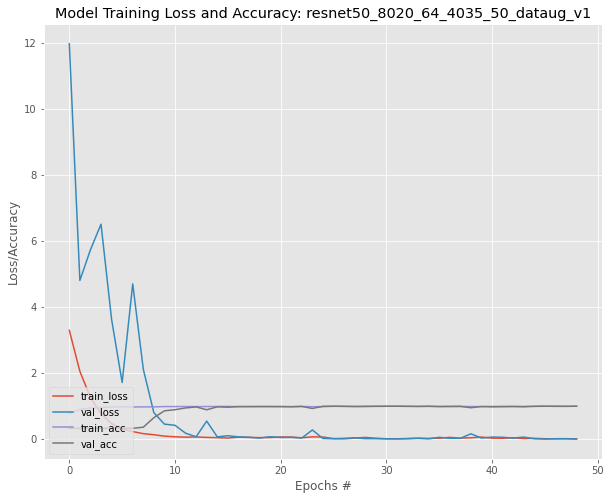

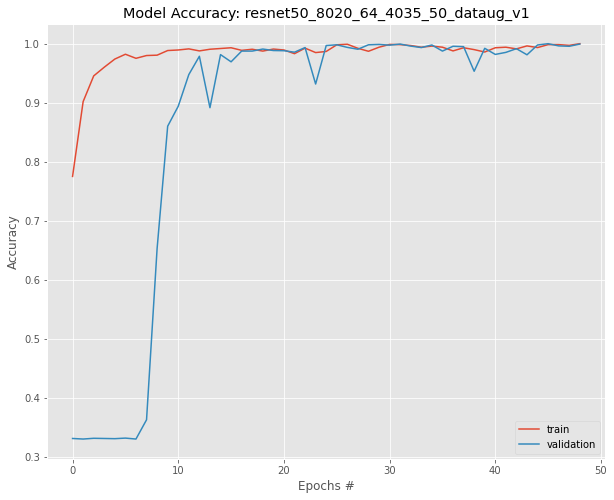

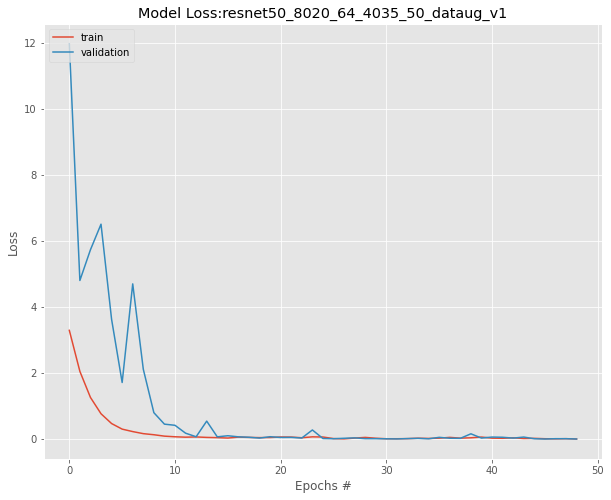

In [26]:
model_plot = ModelChart(history, MODEL_NAME, EPOCHS)

model = model_plot.loss_accuracy_chart(ACCURACY_LOSS_PATH)
accuracy = model_plot.accuracy_chart(ACCURACY_PATH)
loss = model_plot.loss_chart(LOSS_PATH)

---
## Evaluation

We finish the proccess loading the ".h5" model, compiling it and making predictions with the validation data, generating a confussion matrix and classification report with the following characteristics:

* `[precision]` which is the ratio tp / (tp + fp) where tp is the number of true positives and fp the number of false positives. The precision is intuitively the ability of the classifier not to label a negative sample as positive.
* `[recall]` which is the ratio tp / (tp + fn) where tp is the number of true positives and fn the number of false negatives. The recall is intuitively the ability of the classifier to find all the positive samples.
* `[f1-score]` which is a measure combining both precision and recall. It is generally described as the harmonic mean of the two. Harmonic mean is just another way to calculate an “average” of values, generally described as more suitable for ratios (such as precision and recall) than the traditional arithmetic mean.
* `[support]` which is the support is the number of occurrences of each class.

* `[confusion matrix]` which is used to illustrate classifier performance based on the true positive (tp), false positive (fp), true negative (tn) and false negative (fn) values.

* `[sensitivity]` which is a measure of how many of the positive cases the classifier correctly predicted, over all the positive cases in the data.
* `[specificity]` which is a measure of how many negative predictions made are correct (true negatives).

In [27]:
loaded_model = load_model(MODEL_PATH + MODEL_NAME + ".h5")
opt = Adam(lr = INIT_LR, decay = DECAY)
loaded_model.compile(optimizer=opt, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

prob_test_prediction = loaded_model.predict(test_generator)
test_prediction = np.argmax(prob_test_prediction, axis=1)

print(classification_report(y_test.argmax(axis=1), test_prediction, target_names=LABELS))
conf_matrix = confusion_matrix(y_test.argmax(axis=1), test_prediction)

                 precision    recall  f1-score   support

Viral Pneumonia       0.63      0.93      0.75       276
       COVID-19       0.90      0.81      0.85       246
         NORMAL       0.99      0.61      0.75       285

       accuracy                           0.78       807
      macro avg       0.84      0.78      0.79       807
   weighted avg       0.84      0.78      0.78       807



Confusion Matrix

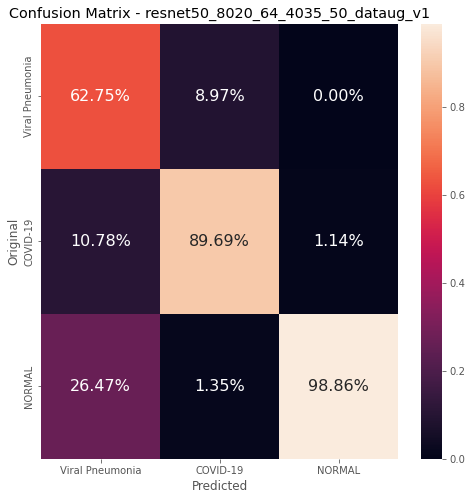

Test Model Accuracy: 0.7807
. . .
Viral Pneumonia Sensitivity: 0.9275
Viral Pneumonia Specificity: 0.7137
Viral Pneumonia Precision: 0.6275
Viral Pneumonia F1-Score: 0.7485
. . .
COVID-19 Sensitivity: 0.8130
COVID-19 Specificity: 0.9590
COVID-19 Precision: 0.8969
COVID-19 F1-Score: 0.8529
. . .
NORMAL Sensitivity: 0.6105
NORMAL Specificity: 0.9962
NORMAL Precision: 0.9886
NORMAL F1-Score: 0.7549


In [28]:
model = ModelEvaluation(conf_matrix, MODEL_NAME)
model.confusion_matrix(CONFUSION_MATRIX_PATH, LABELS)
model.parameters()

ROC AUG curve

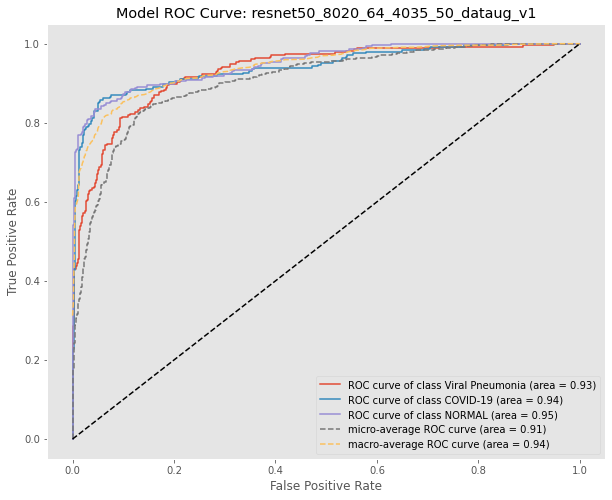

In [30]:
roc_graph = ROC()
roc_metrics = roc_graph.ROC_Curve(y_test, prob_test_prediction)

In [31]:
test_original = np.argmax(y_test, axis=1)

In [32]:
from sklearn.metrics import accuracy_score

accuracy = accuracy_score(test_original, test_prediction)
accuracy

0.7806691449814126

### We are going to store the predictions that were made of our Convolutional Neural Model with the original masks and image paths.

First, we do all the predictions of the images of out model. 

In [33]:
model_prediction = loaded_model.predict(data, batch_size=BS)
model_prediction = np.argmax(model_prediction, axis=1)

prediction = []
for i in range(len(model_prediction)):
    if model_prediction[i] == 0:
        prediction.append("covid")
    if model_prediction[i] == 1:
        prediction.append("normal")
    if model_prediction[i] == 2:
        prediction.append("pneumonia")
    

We call back de dataframe created at the beggining.

In [34]:
covid_db_df = pd.read_csv (
    RAW_DATASET_PATH + 
    RAW_DATASET_NAME + ".csv",  
    )

And at the end, we create de final Dataframe with the images_path, original_masks and predicted_masks of this project.

In [35]:
df_predicted_targets = pd.DataFrame (
    prediction, 
    columns = (['images_predicted_label']), 
    )

covid_db_df_predicted = pd.concat (
    [df['images_path'], df['images_label'], df_predicted_targets],
    axis = 1, 
    join = 'inner'
    )

In [36]:
covid_db_df_predicted.to_csv ( 
    PREDICTED_DATASET_PATH + 
    PREDICTED_DATASET_NAME + ".csv",
    index = False,
    )

Using the `model_prediction` content to visualize a random prediction.

In [37]:
CLASSES[model_prediction[55]]

'COVID-19'

In [4]:
x=2
y=2
z=2
n=2

print([[i, j, k] for i in range(x+1) for j in range(y+1) for k in range(z+1) if i+j+k != n])

[[0, 0, 0], [0, 0, 1], [0, 1, 0], [0, 1, 2], [0, 2, 1], [0, 2, 2], [1, 0, 0], [1, 0, 2], [1, 1, 1], [1, 1, 2], [1, 2, 0], [1, 2, 1], [1, 2, 2], [2, 0, 1], [2, 0, 2], [2, 1, 0], [2, 1, 1], [2, 1, 2], [2, 2, 0], [2, 2, 1], [2, 2, 2]]


In [5]:
for i in range(x+1):
    print(i)

0
1
2
